In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [18]:
df_loc = pd.read_csv('../Data/inmuebles-sample.csv')

In [19]:
# Definir las coordenadas aproximadas de la costa sur de Tenerife (en latitud y longitud)
costa_lat = 28.0700  # Latitud aproximada de la costa sur
costa_lon = -16.5700  # Longitud aproximada de la costa sur

# Función para calcular la distancia en km entre dos coordenadas geográficas
def calcular_distancia(lat1, lon1, lat2, lon2):
    # Convertir grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Fórmula de Haversine
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radio de la Tierra en km
    r = 6371.0
    return r * c

# Calcular la distancia a la costa para cada propiedad
df_loc['distancia_a_costa'] = df_loc.apply(
    lambda row: calcular_distancia(row['latitude'], row['longitude'], costa_lat, costa_lon), axis=1
)


In [20]:
# Definir los rangos de distancia a la costa (en km)
bins = [0, 5, 10, 20, 50, 100]  # Rango de distancias (en km)
labels = ['0-5 km', '5-10 km', '10-20 km', '20-50 km', '50-100 km']

# Crear una nueva columna con el rango de distancia
df_loc['rango_distancia'] = pd.cut(df_loc['distancia_a_costa'], bins=bins, labels=labels, right=False)

# Calcular el precio promedio por rango de distancia
precio_por_distancia = df_loc.groupby('rango_distancia')['price'].mean()
print(precio_por_distancia)

rango_distancia
0-5 km       1170.833333
5-10 km       883.055556
10-20 km     1444.791667
20-50 km      889.742857
50-100 km    1168.428571
Name: price, dtype: float64


C:\Users\heatb\AppData\Local\Temp\ipykernel_11484\943523286.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [21]:
# Calcular las diferencias porcentuales entre cada rango
precio_por_distancia_pct = precio_por_distancia.pct_change() * 100
print(precio_por_distancia_pct)

rango_distancia
0-5 km             NaN
5-10 km     -24.578885
10-20 km     63.612771
20-50 km    -38.417221
50-100 km    31.322051
Name: price, dtype: float64


De 0-5 km a 5-10 km: Hay una disminución del 24.58% en los precios. Esto es interesante, ya que muestra que alejarse de la costa no siempre significa un precio más bajo.

De 5-10 km a 10-20 km: Hay un aumento del 63.61% en los precios, lo cual es un cambio significativo. Esto sugiere que en esta franja, a pesar de estar más lejos de la costa, las propiedades son más caras.

De 10-20 km a 20-50 km: Aquí hay una disminución del 38.42% en los precios, lo que sugiere que en esta franja las propiedades son considerablemente más baratas. Esto puede deberse a que estas zonas son menos accesibles o menos deseables.

De 20-50 km a 50-100 km: Hay un aumento del 31.32% en los precios. A pesar de estar más alejados de la costa, algunas zonas entre 50-100 km de la costa tienen precios comparables a los de las zonas cercanas a la costa, quizás por su proximidad al Teide. 

In [22]:
import os
print(os.getcwd())

c:\Users\heatb\Documents\GitHub\coastal-impact-tenerife\Code


In [23]:
%pip install -q kaleido

fig = px.bar(
    x=precio_por_distancia.index,
    y=precio_por_distancia.values,
    labels={'x': 'Distance to Coast (km)', 'y': 'Average Rental Price (€)'},
    color=precio_por_distancia.index,
    title='Average Rental Price by Distance to the South Coast of Tenerife',
    text=precio_por_distancia.round(2),
    color_discrete_sequence=px.colors.sequential.Blues
)

fig.update_layout(
    xaxis_title="Distance Range to Coast",
    yaxis_title="Average Rental Price (€)",
    title_font_size=18,
    xaxis_tickangle=-45,
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()

# Define la ruta de salida relativa (desde la carpeta Code, retrocede un nivel y entra en Outputs)
output_path = os.path.join("..", "Outputs", "output_graph.html")
fig.write_html(output_path, auto_open=False, include_plotlyjs='cdn')

print(f"Gráfico interactivo guardado en: {os.path.abspath(output_path)}")


Note: you may need to restart the kernel to use updated packages.


Gráfico interactivo guardado en: c:\Users\heatb\Documents\GitHub\coastal-impact-tenerife\Outputs\output_graph.html


In [29]:
# Convertimos la serie en DataFrame para facilitar su uso en Plotly
df_dif = precio_por_distancia_pct.reset_index()
df_dif.columns = ['Rango de Distancia', 'Diferencia Porcentual']

# Crear el gráfico interactivo
fig = px.bar(
    df_dif,
    x='Rango de Distancia',
    y='Diferencia Porcentual',
    color='Diferencia Porcentual',
    color_continuous_scale='RdBu',
    title='Percentage Change in Rental Price by Distance to Coast',
    labels={'Diferencia Porcentual': 'Price Change (%)'}
)

fig.update_layout(
    xaxis_title='Distance Range to Coast',
    yaxis_title='Percentage Price Difference (%)',
    title_x=0.5,
    template='plotly_white'
)

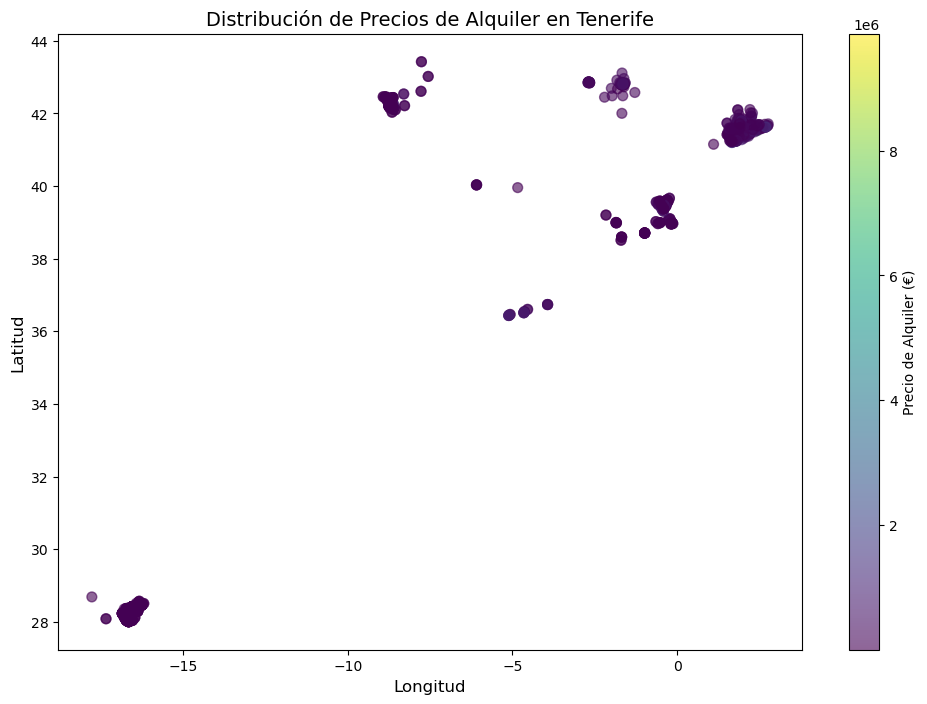

In [25]:
# Visualización básica de la distribución de precios en el mapa
plt.figure(figsize=(12, 8))

# Crear un scatter plot de los precios de alquiler según latitud y longitud
plt.scatter(df_loc['longitude'], df_loc['latitude'], c=df_loc['price'], cmap='viridis', s=50, alpha=0.6)

plt.colorbar(label='Precio de Alquiler (€)')
plt.title('Distribución de Precios de Alquiler en Tenerife', fontsize=14)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.show()


In [26]:
# Convertir los precios promedio y rangos de distancia en un DataFrame para usar con Plotly
df_precio_distancia = pd.DataFrame({
    'rango_distancia': precio_por_distancia.index,
    'precio_promedio': precio_por_distancia.values
})

# Crear un gráfico de barras interactivo
fig = px.bar(df_precio_distancia, x='rango_distancia', y='precio_promedio', title='Precio Promedio de Alquiler por Distancia a la Costa')
fig.update_layout(xaxis_title='Rango de Distancia a la Costa', yaxis_title='Precio Promedio de Alquiler (€)')

# Mostrar el gráfico
fig.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_11484\3022236287.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




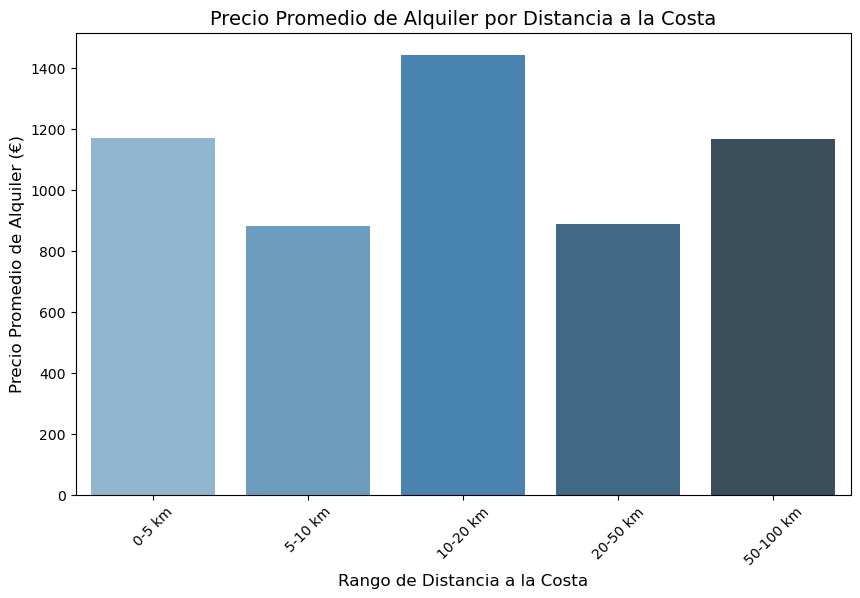

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x=precio_por_distancia.index, y=precio_por_distancia.values, palette='Blues_d')
plt.title('Precio Promedio de Alquiler por Distancia a la Costa', fontsize=14)
plt.xlabel('Rango de Distancia a la Costa', fontsize=12)
plt.ylabel('Precio Promedio de Alquiler (€)', fontsize=12)
plt.xticks(rotation=45)
plt.savefig('precio_por_distancia.png')  # Guardar el gráfico como una imagen
